# 🎅 **Kaggle Santa-2021 - Space Coders - Generating a 2428 solution in 100 lines of code**

Many thanks to the Kaggle team and community for this very interesting optimization competition!  
And congratulations to all, we hope that you enjoyed this puzzle as much as we do 🙂.


We present there our mostly analytical solution.

# First step: ~~2480~~ 2440 without wildcard

We sensed that the high redundancy implied by the mandatory presence in every line of the various 🎅🤶🌟🌟🌟🌟🌟 sequences makes them act as some kind of firewalls. That is, we do not really care about what immediately precedes them, and they can be considered partition points. The optimization problem is actually symmetric on the 5 others symbols (🦌, 🧝, 🎄, 🎁 and 🎀).

> For the sake of readibility, we denote 🎅 and 🤶 respectively  **0** and **1**. We also use the seed ABCDE, an arbitrary sequence of these five other symbols. There are 5! = 120 different permutations of these symbols grouping in 24 cycles : 
ABCDE, BCDEA, CDEAB, DEABC, EABCD are for example 5 permutations of one cycle.
We call **C**(ABCDE), the cycle of the seed ABCDE.


For each ABCDE seed, there is one mandatory permutation to find in every string:
**M**(ABCDE) = **01**ABCDE

and 41 permutations to find in any string, matching with every relative position of 🎅 and 🤶 in the seven symbol permutation. Some examples for ABCDE:
 - **0**A**1**BCDE
 - **0**ABCD**1**E
 - **10**ABCDE
 - AB**1**CD**0**E

It appears quickly that some of these permutations chains very efficiently using only 1 additionnal symbol (or 2 every 8 symbols to prevent repetition):

**01**ABCDE => **1**ABCDE**0** for example. As lot of people solve the problem considering a TSP instance, this would be the distance 1 permutations. 
A**1**BCDE**0** => **1**BCDE**0**A is another interesting example showing that the efficient chaining may be in two different seeds (here ABCDE and BCDEA) but still in the same cycle **C**(ABCDE). Thus, if the five seeds of the same cycle use the same chaining, they compensate each other.

among these 41 permutations, those six have a special status and we call them the **merge permutations** as they can be achieved in any string only by combining the mandatory permutations:
- **1**ABCDE**0**
- A**01**BCDE
- AB**01**CDE
- ABC**01**DE
- ABCD**01**E
- ABCDE**01**

The 35 others are called **regular permutations** hereinafter.



From this, we assumed that finding an efficient chaining of 35 regular permutations after the mandatory **M**(ABCDE) would let us solve the problem by symmetry. With this assumption, the puzzle then boils down to optimizing smaller subproblems for fixed groups. The merge permutations would be covered on the edges when connecting the different efficient chainings and mandatory sequences.

Focusing on this subproblem, after some trial and error we can quickly find the sequence **01**ABCDE**0**A**1**BCDE**0**AB**1**CDE**0**ABC**1**DE**0**ABCD**1**E**0**ABCDE**10**ABCDE of length 48.

>Such a sequence, which we denote **Y**(ABCDE), considered macroscopically as a **M**(ABCDE) to cover the merge permutation. And it is enough to almost arbitrarily split them equally (one third of the groups per line), to get to a 2480 (= 80 x 7 + 40 x 48) solution.
>  
>At first glance this packing seemed optimal without jokers. So given the 2435 LB score of eijirou at the time we reached this score, and as a 45 digits reduction seemed impossible with 2 jokers per line, we initially thought that this simple method using chunks was not appropriate and that we should start to consider this problem as a TSP problem as everyone seemed to do from the early forum posts.
>  
>From a 2480 solution, a 6 digits reduction per joker (leading to a score of 2468) could simply be done by the removal of a **01**BCDEA thanks to the use of **01**ABCDE**0**A**1**BCDE**0**AB**1**CDE**0**ABC**1**DE**0**ABCD**1**E**0**ABCDE**10**🌟BCDEA, denoted **Y'**(ABCDE). This indeed spares the mandatory **M**(BCDEA) of the same string.



Looking closer however we had our first "Aha!" moment: after the first mandatory **01**ABCDE in this sequence we chain 2 unnecessary permutations, which is quite ineffective. These are **1**ABCDE**0** (we already get it for free on the other lines, via **01**ABCDE**01**xxxxx) and ABCDE**0**A (which is not a valid permutation).

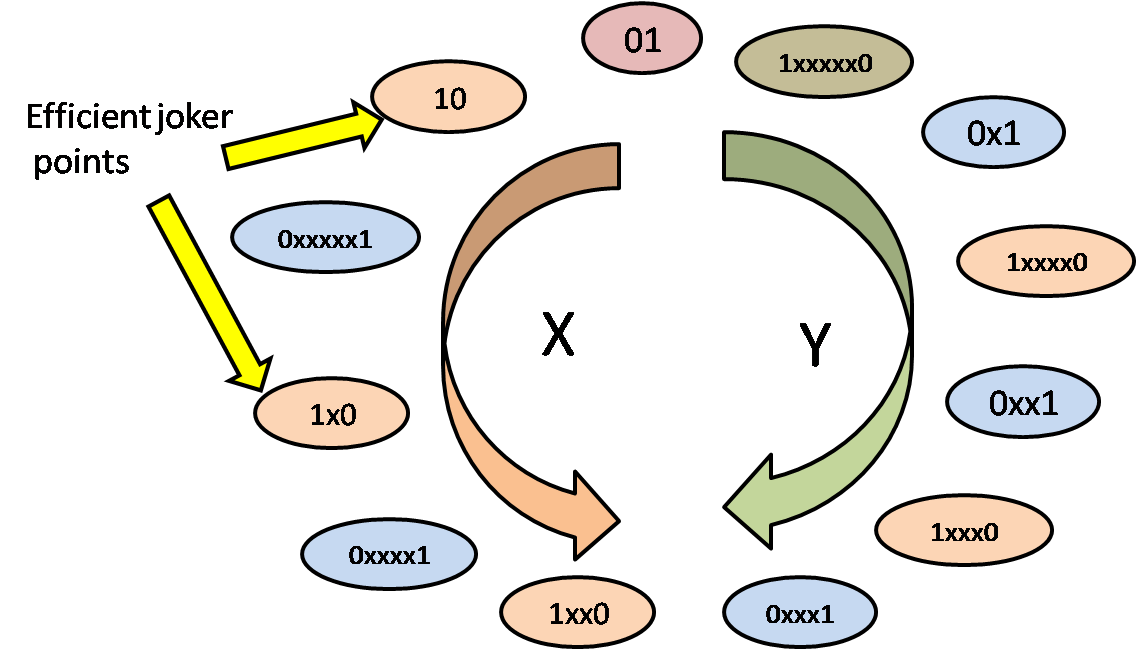

There is a more efficient way to chain the permutations, by reversing the direction of rotation on the above figure.    
**X**(ABCDE) = **01**ABCDE**10**ABCDE**1**A**0**BCDE**1**AB**0**CDE**1**ABC**0**DE**1**ABCD**0**E**1**ABCD~~(E)~~ is 47 characters if we ignore the trailing E. This last character is indeed unnecessary because the **1**ABCDE**0** permutation will be covered by a **01**ABCDE**01**xxxxx on another line.

With the same method as before, we now get 3 lines of length 2440 (= 80 x 7 + 40 x 47) without wildcard! 😀

>From this 2440 solution however, the use of wildcard to get a full 6 digits efficiency was trickier, as we describe in the second section of the notebook.
>
>*A side note about the number of solutions: we clearly see that we can rearrange most chunks as we wish, and balance them differently among lines. So the cardinal of the 2440 solution space is pretty huge!*

# 2440 no joker solution program
Below is a first small program which constructs such a 2440 solution (with digits 0 to 6 in place of the emojis), using the method described above.

As you can see in the code, we grouped **01**ABCDE and its associated rotations **01**BCDEA, **01**CDEAB, **01**DEABC and **01**EABCD into **patterns** to easily ensure the presence of all permutations containing **01** without the need of a post-processing to rearrange chunks (for instance, not to miss an ABCDE**01** permutation, we have every line finish with a different permutation). The 3 patterns are appended to each line with an iterative shifting, driven by the iteration number, to balance the lengths. 
>Note: in our first submissions, we manually edited the generated "solution" to rearrange the chunks in order to recover the missing xx**01**xxx and the like 😅.
>
>This grouping into patterns, explicitely expanded into the code, also facilitated our experiments with wildcards.

In [ ]:
%%writefile santa2021-2440.cpp
#include <fstream>
#include <array>
#include <string>
using namespace std;

int main(int argc, char* argv[]) {
    array<string, 3> lines; // solution under construction ("01" is the mandatory starting sequence, '2' to '6' are the other symbols)
    auto N = 0; // number of iterations performed, in order to keep track of the jokers count and to balance strings' sizes
    string table{"23456"}; // We loop through all permutations of this "table" starting with '2' (only the "3456" part is reordered)
    do {
        // helper to translate "ABCDE" -> current "23456" table
        const auto translate = [&](string chunk) {
            for (auto& c: chunk)
                if (c > '1')
                    c = table[c - 'A'];
            return chunk;
        };
        // Construction of the chunks that will be added to each of the 3 lines for the current table
        const auto patterns = array{ 
            /* line 0 */ "01BCDEA10BCDEA1B0CDEA1BC0DEA1BCD0EA1BCDE0A1BCDE" // =X(BCDEA), just before "01ABCDE" to ensure "BCDE01ABCD"
                         "01ABCDE10ABCDE1A0BCDE1AB0CDE1ABC0DE1ABCD0E1ABCD" // same
                         "01EABCD"
                         "01DEABC"
                         "01CDEAB",

            /* line 1 */ "01ABCDE"
                         "01EABCD10EABCD1E0ABCD1EA0BCD1EAB0CD1EABC0D1EABC" // ...
                         "01DEABC10DEABC1D0EABC1DE0ABC1DEA0BC1DEAB0C1DEAB"
                         "01CDEAB"
                         "01BCDEA", // make sure that the 3 patterns[i] finish with different strings to ensure the presence of all "xxxxx01" in at least one of the lines

            /* line 2 */ "01ABCDE"
                         "01DEABC"
                         "01CDEAB10CDEAB1C0DEAB1CD0EAB1CDE0AB1CDEA0B1CDEA"
                         "01BCDEA"
                         "01EABCD" };                
        // Append chunks to solution
        for (auto line_index: {0, 1, 2})
            lines[(line_index + N) % 3] += translate(patterns[line_index]); // use N to balance the size of the 3 lines
        ++N; // increment the iteration number
    }
    while (next_permutation(table.begin() + 1, table.end())); // End of loop through permutations of table starting with '2'

    // Write solution to file
    ofstream file{"solution-2440.csv"};
    file << "schedule\n";
    for (auto line: lines)
        file << line << "\n";
    return 0;
}

In [ ]:
!g++ -s -O3 -std=c++2a santa2021-2440.cpp -o santa2021-2440.exe && ./santa2021-2440.exe && cat solution-2440.csv

# Second step: Let's make good use of these wildcards! (2430, 2429)

The most efficient way to use a wildcard seems to be the removal of a mandatory **01**ABCDE permutation, as illustrated by the above 2480 -> 2468 transition using **Y**(ABCDE) chunks. And then it becomes quite clear that the joker should take the place of either the **0** or the **1** in this spared mandatory permutation, i.e. **0**🌟**1**xxxxx or **10**🌟xxxxx if we apply it inside an **X**(ABCDE). 

But the use of wildcards is a bit trickier with these new 2440 chunks:  

>**01**ABCDE**10**ABCDE**1**A**0**BCDE**1**AB**0**CDE**1**ABC**0**DE**1**ABCD**0**🌟**1**ABCDE is useless because we would get two occurences of **01**ABCDE in one line...

Another variant is: **X'**(ABCDE) = **01**ABCDE**10**🌟BCDEA**1**B**0**CDEA**1**BC**0**DEA**1**BCD**0**EA**1**BCDE**0**A**1**BCDE, which as for the 2480 case also gives a **01**BCDEA from a **01**ABCDE.
The only problem is that it removes the **0**ABCDE**1** permutation... unless we apply it to each chunk inside a pattern: then this missing permutation reappears in **X'**(EABCD), and so on, the cycle being closed with **X'**(BCDEA)\!  
But only 5 jokers can be used this way, unless:  

*2430 solution:*

>Here is the repartition we considered for the first pattern on the three lines using 6 jokers for our first 2429/2430/2430 solution, admittedly a little contrieved 🤪:   
>  **01**EABCD**10**🌟ABCDE**1**A**0**BCDE**1**AB**0**CDE**1**ABC**0**DE**1**ABCD**0**E**1**ABCD E *(=**X'**(EABCD) + E)*  
>  **01**DEABC  
>  **01**BCDEA**10**🌟CDEAB**1**C**0**DEAB**1**CD**0**EAB**1**CDE**0**AB**1**CDEA**0**B**1**CDEA *(=**X'**(BCDEA))*  
>
>  **01**DEABC**10**🌟EABCD **1**   
>  **01**ABCDEA**1**B**0**CDEA**1**BC**0**DEA**1**BCD**0**EA**1**BCDE**0**🌟**1**BCDEA *(mix)*  
>  **01**CDEAB  
>
>  **01**ABCDE**10**🌟BCDEA **1**  
>  **01**CDEAB**10**🌟DEABC**1**D**0**EABC**1**DE**0**ABC**1**DEA**0**BC**1**DEAB**0**C**1**DEAB *(=**X'**(CDEAB))*  
>  **01**EABCD**1**E**0**ABCD**1**EA**0**BCD**1**EAB**0**CD**1**EABC**0**D**1**EABCD *(mix)* 
>
> In fact there is a much simpler 2430 solution using the **X"** introduced below 😂.

*2429 solution:*

>A much better solution is to use **X"**(ABCDE) = **01**EABCDE**10**ABCDE**1**A**0**BCDE**1**AB**0**CDE**1**ABC**0**DE**1**ABCD**0**🌟**1**ABCDE which (contrary to **X'**) is "compatible" with the other **X**s.
>We place 5 **X'** on a first pattern, and one **X"** for the line with only one joker in the first pattern (accompanied with 4 **X**s). 

And from here we were stuck for several days... until we saw a 2428 on the leaderboard! Wait, what ?? 🤯

# Final step: 2428! 🚀

First, congratulations to Tim Riggins, we did not see 2428 coming!

It's impressive the effect of knowing that a solution exists!  
In about 15 minutes after realizing that 2428 could be attained, and while we really tried hard for some time and convinced ourselves that it was impossible to get to 2428, we found the trick leading to a 2428 solution 😅


Here comes **X'''**(ABCDE) = **01**ABCDE**10**ABCDE**1**A**0**BCDE**1**AB**0**CDE**1**ABC**0**DE**1**ABCD**0**🌟**1**ABC**ED**!

We were so focused on separated independent patterns that we did not dig enough another way of combining twin patterns (ABCDE/ABCED).  
If we combine **X'''**(ABCDE) and **X'''**(ABCED) we get back the **0**E**1**ABCD that we lose over **X**(ABCDE).

And there is the final 2428 solution: just apply a **X'''**(ABCDE) on the first 6 patterns which, because of the way permutations are visited, conveniently involve compatible pairs 🙂.  
R.I.P. **X'**s.


# 2428 solution program
Below is a now 100 lines program which adds wildcards to produce a (digits) 2428 solution.

Since the previous 2440 version above, patterns are here modified for the first 6 groups to add one wildcard per group, via **X'''**(ABCDE).

To simplify things, and to remove the need for a post-processing reassembling the xxxx**01**xxxx missing permutations, the description of consecutive twin joker patterns ABCDE and ABCED are mixed. And finally we pre-insert some targeted **01**xxxxx standalone permutations, which are then filtered when their time comes.

In [ ]:
%%writefile santa2021.cpp
#include <fstream>
#include <vector>
#include <array>
#include <set>
#include <string>
using namespace std;

int main(int argc, char* argv[]) {
    vector<string> lines(3); // solution under construction ("01" is the mandatory starting sequence, '2' to '6' are the other symbols)
    set<string> duplicates; // to simplify jokers management, some temporary permutations are added ahead of time, they will then be ignored when their time comes
    auto N = 0; // number of iterations performed, in order to keep track of the jokers count and to balance strings' sizes
    string table{"23456"}; // We loop through all permutations of this "table" starting with '2' (only the "3456" part is reordered)
    do {
        // helper to translate "ABCDE" -> current "23456" table
        const auto translate = [&](string chunk) {
            for (auto& c: chunk)
                if (c > '1')
                    c = table[c - 'A'];
            return chunk;
        };
        // Construction of the chunks that will be added to each of the 3 lines for the current table
        auto patterns = array{"", "", ""};
        if (N >= 6) // General case (the first 6 permutations will handle jokers, cf. else branch)
            patterns = { "01BCDEA10BCDEA1B0CDEA1BC0DEA1BCD0EA1BCDE0A1BCDE" // just before "01ABCDE" to ensure "BCDE01ABCD"
                         "01ABCDE10ABCDE1A0BCDE1AB0CDE1ABC0DE1ABCD0E1ABCD" // same
                         "01EABCD"
                         "01DEABC"
                         "01CDEAB",

                         "01ABCDE"
                         "01EABCD10EABCD1E0ABCD1EA0BCD1EAB0CD1EABC0D1EABC" // ...
                         "01DEABC10DEABC1D0EABC1DE0ABC1DEA0BC1DEAB0C1DEAB"
                         "01CDEAB"
                         "01BCDEA", // make sure that the 3 patterns[i] finish with different strings to ensure the presence of all "xxxxx01" in at least one of the lines

                         "01ABCDE"
                         "01DEABC"
                         "01CDEAB10CDEAB1C0DEAB1CD0EAB1CDE0AB1CDEA0B1CDEA"
                         "01BCDEA"
                         "01EABCD" };
        else { // if N < 6: one joker for the first 6 permutations
            if (N % 2 == 0) // work simultaneously with pairs 01ABCDE/01ABCED (this was the trick to go from 2430 to 2428)
                patterns = { "01BCEDA"
                             "01BCDEA10BCDEA1B0CDEA1BC0DEA1BCD0EA1BCDE0A1BCDE"
                             "01ABCDE10ABCDE1A0BCDE1AB0CDE1ABC0DE1ABCD0*1ABCED" // here we lost "BCD01EABC" (added as a duplicate below) + "ABCD01E"
                             "01EABCD10EABCD1E0ABCD1EA0BCD1EAB0CD1EABC0D1EABC"
                             "01DEABC"
                             "01EDABC"
                             "01CEDAB"
                             "01CDEAB"
                             "01DABCE",

                             "01CDEAB"
                             "01CEDAB"
                             "01EABCD"
                             "01BCDEA"
                             "01BCEDA10BCEDA1B0CEDA1BC0EDA1BCE0DA1BCED0A1BCED"
                             "01ABCED10ABCED1A0BCED1AB0CED1ABC0ED1ABCE0*1ABCDE" // here we lost "BCE01DABC" (added as a duplicate below) + "ABCE01D"
                             "01DABCE10DABCE1D0ABCE1DA0BCE1DAB0CE1DABC0E1DABC"
                             "01EDABC"
                             "01DEABC",

                    "01ADBCE""01DABCE" // we will need to remove this introduced duplicate "01ADBCE"
                             "01DEABC10DEABC1D0EABC1DE0ABC1DEA0BC1DEAB0C1DEAB" // chaining with previous chunk ensure "ABCE01D"
                             "01CDEAB10CDEAB1C0DEAB1CD0EAB1CDE0AB1CDEA0B1CDEA"
                             "01BCDEA"
                             "01ABCDE"
                             "01ABCED"
                    "01AEBCD""01EABCD" // we will need to remove this introduced duplicate
                             "01EDABC10EDABC1E0DABC1ED0ABC1EDA0BC1EDAB0C1EDAB" // ensure "ABCD01E"
                             "01CEDAB10CEDAB1C0EDAB1CE0DAB1CED0AB1CEDA0B1CEDA"
                             "01BCEDA" };

            duplicates.insert(translate("01AEBCD")); // will also add "01ADBCE" when N % 2 != 0
        }
        // Duplicates removal
        const auto potential_duplicate = translate("01ABCDE");
        if (duplicates.contains(potential_duplicate))
            for (auto i = 2; i >= 0; --i)
                if (lines[(i + N) % 3].find(potential_duplicate) != string::npos) {
                    if (i == 0) // patterns[0] does not start with "01ABCDE" which we want to remove
                        swap (patterns[1], patterns[0]); // we then swap pattern 1 and 0 which conveniently have the same size
                    patterns[i] = patterns[i] + 7; // remove leading "01ABCDE"
                    break;
                }
        // Append chunks to solution
        for (auto line_index: {0, 1, 2})
            lines[(line_index + N) % 3] += translate(patterns[line_index]); // use N to balance the size of the 3 lines
        ++N; // increment the iteration number
    }
    while (next_permutation(table.begin() + 1, table.end())); // End of loop through permutations of table starting with '2'

    // Write solution to file
    ofstream file{"solution.csv"};
    file << "schedule\n";
    for (auto line: lines)
        file << line << "\n";
    return 0;
}

In [ ]:
!g++ -s -O3 -std=c++2a santa2021.cpp -o santa2021.exe && ./santa2021.exe && cat solution.csv

Let's eventually replace those digits with the pretty themed emojis to create a valid submission file (ok, with this final post-processing step, the full code is indeed more about 120 lines 😇):

In [ ]:
import pandas as pd

SYMBOLS = "🎅🤶🦌🧝🎄🎁🎀"
WILDCARD = "🌟"

with open("solution.csv", "r") as fin:
    solution = fin.readlines()
    
for i in range(3):
    solution[i+1] = solution[i+1].rstrip(" \n").replace("*", WILDCARD)
    for j in range(7):
        solution[i+1] = solution[i+1].replace(str(j), SYMBOLS[j])
    print("line %d length %d" % (i, len(solution[i+1])))
    
# generate submission
sub = pd.DataFrame()
sub['schedule'] = solution[1:]
sub.to_csv('submission.csv',index=False)
sub.head()

# Going further

We initialized a tool which took various parameters of the problem as inputs to be quickly able to produce a potential solution, should a reset be triggered. Those inputs were:
- the permutation size
- the number of lines
- the number of jokers per line

This is indeed not so hard, the principles beeing similar to those presented above, balancing the use of **X**, **Y**, and their joker variants.  
Though this time a final assembly to recover the missing xxxx**01**xxxx is  added as a post-processing step instead of a pre-analysis of the patterns.

We leave the implementation of such a program as an exercise for the interested reader 😋.  
Our take on the similar {8 size permutations / 3 lines / 2 jokers per line} problem has for instance a score of 18706 😉. This case is indeed surprisingly simpler in a sense than the original problem as there are here 6 jokers for 6 big chunks per pattern, hence the use of **X'** is sufficient.

Thank you all for reading 😊  
And again many thanks to the Kaggle team for this very interesting challenge; we will certainly soon try to participate in the more involving machine learning competitions!